In [1]:
import os
import sys
import h5py
import PIL
import tqdm
import torch
from torch.utils.data import Dataset
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from src.likelihoods import GaussianBagLikelihood
from src.models import VariationalGP

In [2]:
def generate_toy_2d_dataset(seed, n_bags):
    # Set random seed for reproducibility
    np.random.seed(seed)
    n_bags = n_bags + 1
    
    # Define latent groundtruth mapping
    amplitude = 4
    x1 = np.linspace(0, 1, 25)
    x2 = np.linspace(0, 1, 25)
    x = np.dstack(np.meshgrid(x1, x2))
    y = amplitude * (np.sin(3 * np.pi * (x.sum(axis=-1))) - np.sin(4 * np.pi * (x[..., 0] - x[..., 1])))
    
    # Split individuals inputs and observations into bags based on targets ranges
    ranges_delimiters = np.linspace(y.min(), y.max(), n_bags)
    bags_masks = [(y > amin) & (y < amax) for (amin, amax) in zip(ranges_delimiters[:-1], ranges_delimiters[1:])]
    bags = [torch.from_numpy(x[mask]) for mask in bags_masks]
    individual_targets = [torch.from_numpy(y[mask]) for mask in bags_masks]
    
    # Aggregate individual observation and add some noise
    aggregated_bags_targets = torch.Tensor([y[mask].mean() for mask in bags_masks])
    eps = np.sqrt(0.04) * torch.randn_like(aggregated_bags_targets)
    aggregated_bags_targets = aggregated_bags_targets + eps
    return bags, aggregated_bags_targets, individual_targets, bags_masks, (x1, x2), y

In [3]:
bags, bags_targets, individual_targets, bags_masks, (x1, x2), y = generate_toy_2d_dataset(seed=5, n_bags=4)
bags_sizes = torch.IntTensor(list(map(len, bags)))
stacked_bags = torch.cat(bags).float()

# Create bags 2D visualization image
bags_plot = y.copy()
for i, mask in enumerate(bags_masks):
    bags_plot[mask] = bags_plot[mask].mean()

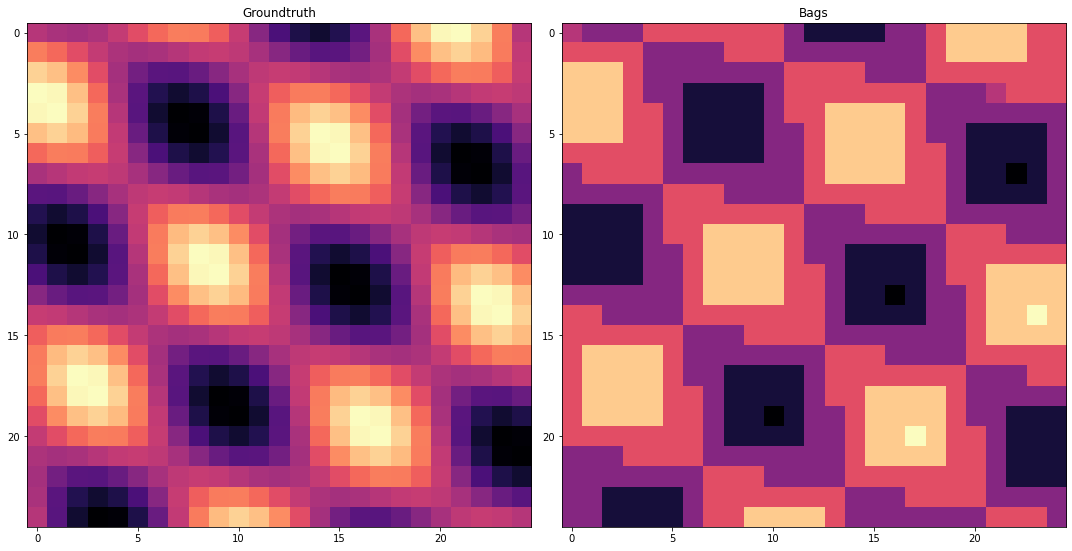

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].imshow(y, cmap='magma')
ax[0].set_title("Groundtruth")

ax[1].imshow(bags_plot, cmap='magma')
ax[1].set_title("Bags")

plt.tight_layout()
plt.show()

### Setup Model

In [5]:
from gpytorch import means, kernels

In [6]:
landmark_points = stacked_bags[::10]
print("Landmark points : ", landmark_points.shape)

Landmark points :  torch.Size([62, 2])


In [7]:
grid = torch.from_numpy(np.dstack([x1, x2])).squeeze().float()


mean_module = means.ConstantMean()
covar_module = kernels.GridKernel(kernels.ScaleKernel(kernels.RBFKernel()), grid=grid)

model = VariationalGP(landmark_points=landmark_points,
                      mean_module=mean_module,
                      covar_module=covar_module)

likelihood = GaussianBagLikelihood()

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(stacked_bags))

### Train

In [8]:
epochs = 400

model.train()
likelihood.train()

parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=0.1)


epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for epoch in epoch_iter:
    optimizer.zero_grad()
    variational_posterior_distribution = model(stacked_bags)
    loss = -elbo(variational_posterior_distribution, bags_targets, bags_sizes=bags_sizes)
    epoch_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
    
print("Train ELBO = ", torch.exp(-loss).item())

RuntimeError: python_error

In [16]:
x = torch.from_numpy(np.dstack(np.meshgrid(x1, x2)).reshape(-1, 2)).float()
print("Input shape : ", x.shape)

Input shape :  torch.Size([625, 2])


In [17]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x))

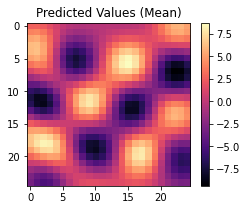

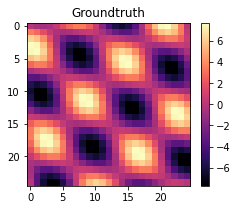

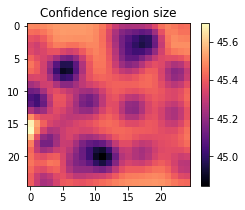

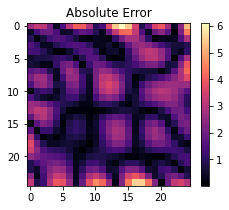

In [19]:
pred_labels = observed_pred.mean.view(25, 25)
confidence_region = observed_pred.confidence_region()
variance = confidence_region[1].sub(confidence_region[0]).view(25, 25)

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels, cmap='magma')
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Mean)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, y, 'Groundtruth')

# Plot confidence region size
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, variance, 'Confidence region size')

# Plot absolute error
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, torch.abs(pred_labels - y), 'Absolute Error')